In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

import torch
import transformers

from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

tokenizer_bbu = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)


from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification



tokenizer_bbu = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

import random
import torch
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


cuda


In [3]:
import pandas as pd
resumeDataSet = pd.read_csv('/content/drive/MyDrive/Thesis_Niiaz/dataset_lm.csv' ,encoding='utf-8')
resumeDataSet.head()


label_dict = {'primary_teacher' : 6,
              'kg_teacher' : 3,
              'esl_teacher' : 1,
              'ict_teacher' : 2,
              'science_teacher' : 7,
              'music_teacher' : 5,
              'math_teacher' : 4,
              'art_teacher' : 0
              }


from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(resumeDataSet.index.values, 
                                                  resumeDataSet.position.values, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=resumeDataSet.position.values)

resumeDataSet['data_type'] = ['not_set']*resumeDataSet.shape[0]
resumeDataSet.loc[X_train, 'data_type'] = 'train'
resumeDataSet.loc[X_val, 'data_type'] = 'val'

In [4]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        accuracy = len(y_preds[y_preds==label])/len(y_true)
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {accuracy}\n')


def evaluate(model, dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [42]:
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 8

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)
print(device)

cuda


In [44]:
model_bbu.load_state_dict(torch.load('/content/drive/MyDrive/Thesis_Niiaz/finetuned_BERT_512_epoch_3.model', map_location=torch.device('cpu')))
_, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)

In [45]:
predicted = []
for pred in predictions:
  predicted.append(np.argmax(pred))

y_test = true_vals

In [46]:
classes = ['art', 'esl', 'ict', 'kg',
       'math', 'music', 'primary',
       'science']

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

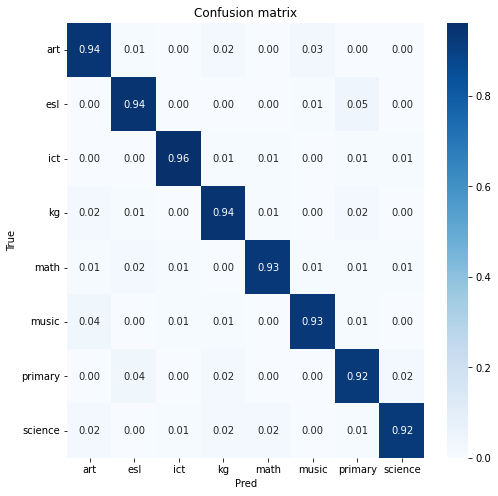

In [47]:
## Plot confusion matrix
import seaborn as sns
cm = metrics.confusion_matrix(y_test, predicted)
cm = cm / [sum(cm[0]), sum(cm[1]), sum(cm[2]), sum(cm[3]), sum(cm[4]), sum(cm[5]), sum(cm[6]), sum(cm[7])]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='.2f', ax=ax, cmap=plt.cm.Blues, 
            )
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

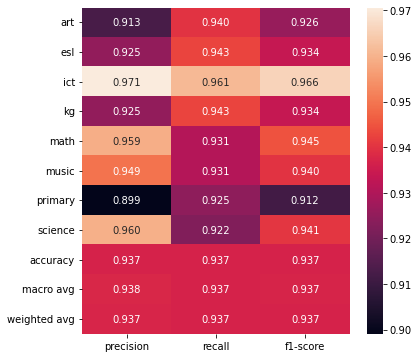

In [48]:
from sklearn.metrics import classification_report

#labels = np.arange(10)


clf_report = classification_report(y_test,
                                   predicted,
                                   #labels=labels,
                                   target_names=classes,
                                   output_dict=True)


# .iloc[:-1, :] to exclude support
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, fmt=".3f", ax=ax)

In [49]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 21.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=a928cf7c9bf3deda0e23562f0bf5bfe63214d05efe8f3b621c159a6bc793c397
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

In [50]:
!pip install eli5
import eli5

eli5.show_weights(model_bbu, top=10)

In [ ]:
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 8

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    if epoch > 1:
      torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/Thesis_Niiaz/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


#res = pd.read_csv('/content/drive/MyDrive/Thesis_Niiaz/results2.csv', encoding='utf-8')
    
#res = res.append(results, ignore_index=True)

#results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0525516467440186
Validation loss: 0.3695308605878099
F1 Score (Weighted): 0.9073245646864615


Epoch 2:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.29454378844736123
Validation loss: 0.29964471407668686
F1 Score (Weighted): 0.9235419410308817


Epoch 3:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2035743293908506
Validation loss: 0.29783802412142885
F1 Score (Weighted): 0.9370105235738744


Epoch 4:   0%|          | 0/412 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [13]:
model_bbu.labels

AttributeError: ignored

In [ ]:
`resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:550])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]


# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 8

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


#res = pd.read_csv('/content/drive/MyDrive/Thesis_Niiaz/results2.csv', encoding='utf-8')
    
#res = res.append(results, ignore_index=True)

#results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: ignored

In [ ]:
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 3
batch_size = 8

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)

torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_512_epoch_{epoch}.model')

#res = pd.read_csv('/content/drive/MyDrive/Thesis_Niiaz/results2.csv', encoding='utf-8')
    
#res = res.append(results, ignore_index=True)

#results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0843525877566014
Validation loss: 0.38500142907633367
F1 Score (Weighted): 0.9047182824513776


Epoch 2:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.32404010068372036
Validation loss: 0.314934311326123
F1 Score (Weighted): 0.9213375499395725


Epoch 3:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2240460942074367
Validation loss: 0.318161972816491
F1 Score (Weighted): 0.92116734757801


In [ ]:
model_bbu.load_state_dict(torch.load('/content/drive/MyDrive/finetuned_BERT_512_epoch_3.model', map_location=torch.device('cpu')))
_, predictions, true_vals = evaluate(model_bbu,dataloader_validation_bbu)
accuracy_per_class(predictions, true_vals)

Class: art_teacher
Accuracy: 0.94

Class: esl_teacher
Accuracy: 0.9523809523809523

Class: ict_teacher
Accuracy: 0.912621359223301

Class: kg_teacher
Accuracy: 0.9142857142857143

Class: math_teacher
Accuracy: 0.9207920792079208

Class: music_teacher
Accuracy: 0.9405940594059405

Class: primary_teacher
Accuracy: 0.8773584905660378

Class: science_teacher
Accuracy: 0.912621359223301



In [ ]:
predict = []
for pred in predictions:
  predict.append(np.argmax(pred))

In [ ]:
len(predict), len(true_vals)

(824, 824)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

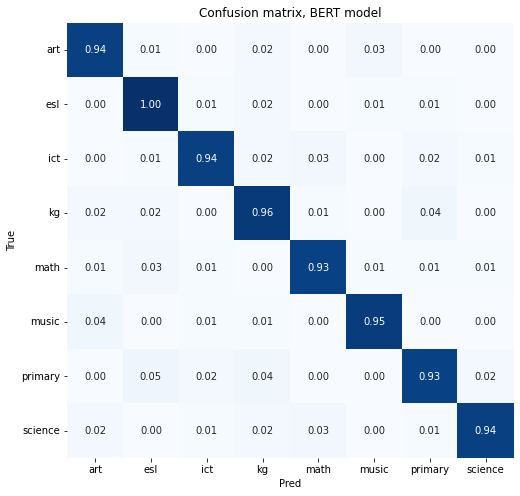

In [ ]:
## Plot confusion matrix
cm = metrics.confusion_matrix(true_vals, predict)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm/100, annot=True, fmt='.2f', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix, BERT model")
plt.yticks(rotation=0)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
classes = ['art', 'esl', 'ict', 'kg',
       'math', 'music', 'primary',
       'science']

In [ ]:
import torch
import torch.nn.functional as F
from sklearn import metrics
 
y_preds = []
y_trues = []
for index,val_text in enumerate(val_texts):
     tokenized_val_text = tokenizer([val_text], 
                                    truncation=True,
                                    padding=True,
                                    return_tensor='pt')
     logits = model(tokenized_val_text)
     prediction = F.softmax(logits, dim=1)
     y_pred = torch.argmax(prediction).numpy()
     y_true = val_labels[index]
     y_preds.append(y_pred)
     y_trues.append(y_true)

In [ ]:

# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 10

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2403872404586185
Validation loss: 0.415452038218458
F1 Score (Weighted): 0.8988247829889501


Epoch 2:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3314718143280708
Validation loss: 0.31089288018733624
F1 Score (Weighted): 0.9197290533976953


Epoch 3:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2095985752784393
Validation loss: 0.29335661508502014
F1 Score (Weighted): 0.9334398656824492


Epoch 4:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.15743433408100496
Validation loss: 0.31018827102113383
F1 Score (Weighted): 0.9320425512918149


Epoch 5:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.13186753084036437
Validation loss: 0.3189495416548866
F1 Score (Weighted): 0.9322097859640734


In [ ]:

# updated cv
max_length = 512
lr_ = 5e-6
eps_ = 1e-8
epochs = 5
batch_size = 8

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.509963525007072
Validation loss: 0.6995584270329152
F1 Score (Weighted): 0.8563920923553234


Epoch 2:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4973421194635838
Validation loss: 0.36226179646056833
F1 Score (Weighted): 0.9174815635489564


Epoch 3:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.28852747232445236
Validation loss: 0.31700571351549
F1 Score (Weighted): 0.9223376221744002


Epoch 4:   0%|          | 0/412 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.22584718123566613
Validation loss: 0.31638584027374256
F1 Score (Weighted): 0.924731131448766


Epoch 5:   0%|          | 0/412 [00:00<?, ?it/s]

In [ ]:

# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 9

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2854506099946816
Validation loss: 0.381704726944799
F1 Score (Weighted): 0.9161736536294329


Epoch 2:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3262227176858635
Validation loss: 0.28993144183946046
F1 Score (Weighted): 0.9283558816233047


Epoch 3:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2037365588001724
Validation loss: 0.2844208894884619
F1 Score (Weighted): 0.9333663448574514


Epoch 4:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.1619513445186152
Validation loss: 0.3049401571245297
F1 Score (Weighted): 0.9310796793599987


Epoch 5:   0%|          | 0/367 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.1334719247659237
Validation loss: 0.325683320923101
F1 Score (Weighted): 0.9322954679544303


In [ ]:

# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 7

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:550])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/471 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0222806652608445
Validation loss: 0.3469978368257062
F1 Score (Weighted): 0.9088090471119684


Epoch 2:   0%|          | 0/471 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2743396365267646
Validation loss: 0.3004593367498936
F1 Score (Weighted): 0.9295767194847887


Epoch 3:   0%|          | 0/471 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.19777707777316278
Validation loss: 0.32556344126745806
F1 Score (Weighted): 0.929786627721876


Epoch 4:   0%|          | 0/471 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.149602447519763
Validation loss: 0.34381738214130053
F1 Score (Weighted): 0.9248417013495926


Epoch 5:   0%|          | 0/471 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.11993231513140024
Validation loss: 0.36662608257423834
F1 Score (Weighted): 0.9263363290920552


In [ ]:

# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 8

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


#res = pd.read_csv('/content/drive/MyDrive/Thesis_Niiaz/results2.csv', encoding='utf-8')
    
#res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results2.csv', encoding='utf-8')

In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    a = (len_ - 512) // 2
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[a:-a])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 3

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


#res = pd.read_csv('/content/drive/MyDrive/Thesis_Niiaz/results1.csv', encoding='utf-8')
    
#res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: ignored

In [ ]:
# tail
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[-512:])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 3

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9090854680967315
Validation loss: 0.5207590401714498
F1 Score (Weighted): 0.8825148137093571


Epoch 2:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.45262616777155307
Validation loss: 0.6163526703383435
F1 Score (Weighted): 0.8725666805290636


Epoch 3:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.35577223656940155
Validation loss: 0.6561956745521589
F1 Score (Weighted): 0.8804874359787137


Epoch 4:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.26385967645913216
Validation loss: 0.7236001882774078
F1 Score (Weighted): 0.8801588312659158


Epoch 5:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.20687543115370124
Validation loss: 0.7458581872720441
F1 Score (Weighted): 0.8779403323940336


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[:200] + resumeDataSet['cv'][cv].split()[:-312])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 3

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8785813094054885
Validation loss: 0.4078097357177599
F1 Score (Weighted): 0.9075880547888316


Epoch 2:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3601620267128387
Validation loss: 0.4535358433594758
F1 Score (Weighted): 0.9089660705065791


Epoch 3:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.28489115172077656
Validation loss: 0.4565736874396151
F1 Score (Weighted): 0.9127649179184015


Epoch 4:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2083132812026439
Validation loss: 0.517170750116506
F1 Score (Weighted): 0.9077574180368805


Epoch 5:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.16448518710291002
Validation loss: 0.5184404685024426
F1 Score (Weighted): 0.907780617837595


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[:50] + resumeDataSet['cv'][cv].split()[:-462])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 3

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8451739505214703
Validation loss: 0.4886222394064746
F1 Score (Weighted): 0.8857320773272982


Epoch 2:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.35692781780857435
Validation loss: 0.4975575465061278
F1 Score (Weighted): 0.899295757320906


Epoch 3:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.28182281754585536
Validation loss: 0.5178132600807162
F1 Score (Weighted): 0.9007568975061496


Epoch 4:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.210100593576373
Validation loss: 0.5580335042519834
F1 Score (Weighted): 0.8966814965258025


Epoch 5:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.15420047188342106
Validation loss: 0.5628137092829936
F1 Score (Weighted): 0.9004406705414324


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:550])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 3

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


#res = pd.read_csv('/content/drive/MyDrive/results1.csv', encoding='utf-8')
    
#res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7902438915254136
Validation loss: 0.42177352021871645
F1 Score (Weighted): 0.9163950322017803


Epoch 2:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.29618234389751397
Validation loss: 0.3801494312227111
F1 Score (Weighted): 0.9247615964463198


Epoch 3:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.22960849272608808
Validation loss: 0.464002889953977
F1 Score (Weighted): 0.9250366381427886


Epoch 4:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.15652393443328586
Validation loss: 0.4384540327670137
F1 Score (Weighted): 0.9296767747677864


Epoch 5:   0%|          | 0/1099 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12123406242765232
Validation loss: 0.459895064750136
F1 Score (Weighted): 0.9223701406389864


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:550])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 10

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2407580735105457
Validation loss: 0.4365683284150549
F1 Score (Weighted): 0.8883656820502351


Epoch 2:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.327581210377993
Validation loss: 0.3017468695270728
F1 Score (Weighted): 0.9174343670731745


Epoch 3:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.205081654819801
Validation loss: 0.3149770351508296
F1 Score (Weighted): 0.9250539441097949


Epoch 4:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.15932151973811967
Validation loss: 0.31642022859641766
F1 Score (Weighted): 0.9295695178725308


Epoch 5:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12710023769318607
Validation loss: 0.3208116574987141
F1 Score (Weighted): 0.932191875399131


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[15:540])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 6
batch_size = 10

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2755088946584499
Validation loss: 0.4705050276165985
F1 Score (Weighted): 0.8816761962262467


Epoch 2:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3394816029816866
Validation loss: 0.3208040646221264
F1 Score (Weighted): 0.9150551637743576


Epoch 3:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.21004754497359196
Validation loss: 0.32823879253792476
F1 Score (Weighted): 0.9236732945026024


Epoch 4:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.15922648772653758
Validation loss: 0.35387642381443496
F1 Score (Weighted): 0.9261147100560428


Epoch 5:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12984533271554743
Validation loss: 0.3663242908800582
F1 Score (Weighted): 0.9236854670540082


Epoch 6:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.10669800931531372
Validation loss: 0.368224600952747
F1 Score (Weighted): 0.9236315065154406


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:560])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 1e-5
eps_ = 1e-8
epochs = 5
batch_size = 10

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.3284162018335226
Validation loss: 0.4460767267877797
F1 Score (Weighted): 0.9001447117940421


Epoch 2:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.338266520010251
Validation loss: 0.33218225834509696
F1 Score (Weighted): 0.9154210305150711


Epoch 3:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2138289105260011
Validation loss: 0.3221832847402218
F1 Score (Weighted): 0.9200445292513938


Epoch 4:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.16315397268274065
Validation loss: 0.3332526223195425
F1 Score (Weighted): 0.9247556398987152


Epoch 5:   0%|          | 0/330 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.13223775710459007
Validation loss: 0.3298836228751903
F1 Score (Weighted): 0.9272600039880853


In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:550])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 2e-5
eps_ = 1e-8
epochs = 6
batch_size = 32

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results_NEWEST.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results_NEWEST.csv', encoding='utf-8')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/103 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
resumeDataSet['cv_'] = 0 
for cv in range(len(resumeDataSet['cv'])):
  len_ = len(resumeDataSet['cv'][cv].split())
  if  len_ > 512:
    resumeDataSet['cv_'][cv] = ' '.join(resumeDataSet['cv'][cv].split()[5:550])
  else:
    resumeDataSet['cv_'][cv] = resumeDataSet['cv'][cv]

    
# updated cv
max_length = 512
lr_ = 3e-5
eps_ = 1e-8
epochs = 6
batch_size = 10

encoded_data_train_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='train'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val_bbu = tokenizer_bbu.batch_encode_plus(
    resumeDataSet[resumeDataSet.data_type=='val'].cv_.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train_bbu = encoded_data_train_bbu['input_ids']
attention_masks_train_bbu = encoded_data_train_bbu['attention_mask']
labels_train_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='train'].position.values)

input_ids_val_bbu = encoded_data_val_bbu['input_ids']
attention_masks_val_bbu = encoded_data_val_bbu['attention_mask']
labels_val_bbu = torch.tensor(resumeDataSet[resumeDataSet.data_type=='val'].position.values)



dataset_train_bbu = TensorDataset(input_ids_train_bbu, attention_masks_train_bbu, labels_train_bbu)
dataset_val_bbu = TensorDataset(input_ids_val_bbu, attention_masks_val_bbu, labels_val_bbu)



model_bbu = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)






from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


dataloader_train_bbu = DataLoader(dataset_train_bbu, 
                              sampler=RandomSampler(dataset_train_bbu), 
                              batch_size=batch_size)

dataloader_validation_bbu = DataLoader(dataset_val_bbu, 
                                   sampler=SequentialSampler(dataset_val_bbu), 
                                   batch_size=batch_size)



from transformers import AdamW, get_linear_schedule_with_warmup

optimizer_bbu = AdamW(model_bbu.parameters(),
                  lr=lr_, 
                  eps=eps_)






scheduler_bbu = get_linear_schedule_with_warmup(optimizer_bbu, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_bbu)*epochs)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bbu.to(device)

results = pd.DataFrame()
for epoch in tqdm(range(1, epochs+1)):
    
    model_bbu.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_bbu, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_bbu.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_bbu(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bbu.parameters(), 1.0)

        optimizer_bbu.step()
        scheduler_bbu.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    #torch.save(model_bbu.state_dict(), f'/content/drive/MyDrive/BERT_models/finetuned_BERT_512_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_bbu)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model_bbu, dataloader_validation_bbu)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    results = results.append({'epoch' : epoch,
                    'max_length' : max_length,
                    'batch_size' : batch_size,
                    'lr_rate' : lr_,
                    'eps': eps_,
                    'train_loss' : loss_train_avg,
                    "val_loss" : val_loss,
                    "val_f1" : val_f1
          }, ignore_index=True)


res = pd.read_csv('/content/drive/MyDrive/results_NEW.csv', encoding='utf-8')
    
res = res.append(results, ignore_index=True)

results.to_csv('/content/drive/MyDrive/results_NEWEST.csv', encoding='utf-8')
